In [1]:
#import my model from my drive
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/n00bmaster68/ApplyingSODinAutoLabelling

#check whether device has GPU
import tensorflow as tf
tf.test.gpu_device_name()

Mounted at /content/gdrive
Cloning into 'ApplyingSODinAutoLabelling'...
remote: Enumerating objects: 2108, done.
remote: Counting objects: 100% (2108/2108), done.
remote: Compressing objects: 100% (2084/2084), done.
remote: Total 2108 (delta 23), reused 2092 (delta 11), pack-reused 0
Receiving objects: 100% (2108/2108), 75.58 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (23/23), done.


'/device:GPU:0'

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a4e3bfc4-bdad-992f-9a2e-2ce537110c44)


In [3]:
import os
import time
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow 
import glob
 
from ApplyingSODinAutoLabelling.data_loader import RescaleT
from ApplyingSODinAutoLabelling.data_loader import CenterCrop
from ApplyingSODinAutoLabelling.data_loader import ToTensor
from ApplyingSODinAutoLabelling.data_loader import ToTensorLab
from ApplyingSODinAutoLabelling.data_loader import SalObjDataset

from ApplyingSODinAutoLabelling.model import BASNet

In [4]:
def normPRED(d):
	ma = torch.max(d)
	mi = torch.min(d)

	dn = (d-mi)/(ma-mi)
	return dn

In [5]:
def save_output(image_name,pred,d_dir):
	predict = pred
	predict = predict.squeeze()
	predict_np = predict.cpu().data.numpy()

	im = Image.fromarray(predict_np*255).convert('RGB')
	img_name = image_name.split("/")[-1]
	image = io.imread(image_name)
	imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)
	# imo.show()
	getCoordinate(imo)

In [6]:
def getCoordinate(imo):
  opencvImage = cv2.cvtColor(np.array(imo), cv2.COLOR_RGB2BGR)
  height, width, _ = opencvImage.shape
  # cv2_imshow(cv2.resize(opencvImage, (int(width/2), int(height/2)), interpolation = cv2.INTER_AREA))

  lower = [np.mean(opencvImage[:,:,i] - np.std(opencvImage[:,:,i])/3 ) for i in range(3)]
  upper = [250, 250, 250]
  
  # create NumPy arrays from the boundaries
  lower = np.array(lower, dtype="uint8")
  upper = np.array(upper, dtype="uint8")
  
  # find the colors within the specified boundaries and apply
  mask = cv2.inRange(opencvImage, lower, upper)
  output = cv2.bitwise_and(opencvImage, opencvImage, mask=mask)
  
  ret,thresh = cv2.threshold(mask, 40, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  largest_contour = max(contours, key = cv2.contourArea)
  x,y,w,h = cv2.boundingRect(largest_contour)

  cv2_imshow(cv2.resize(cv2.rectangle(opencvImage,(x,y),(x+w,y+h),(0,255,0),2), (int(width/2), int(height/2)), interpolation = cv2.INTER_AREA))

  print(x/width, y/height, w/width, h/height)
  print(f"x:{x}, y:{y}, hW:{h}, wW:{w}")
  print(f"Height:{height}, Weight:{width}")

In [7]:
# --------- 1. get image path and name ---------
image_dir = 'ApplyingSODinAutoLabelling/test_data/test_images/'
prediction_dir = 'ApplyingSODinAutoLabelling/test_data/test_results/'
model_dir = '/content/gdrive/MyDrive/SODmodels/basnet.pth'
img_name_list = glob.glob(image_dir + '*.jpg')

In [8]:
# --------- 2. dataloader ---------
#1. dataload
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list, lbl_name_list = [],transform=transforms.Compose([RescaleT(256),ToTensorLab(flag=0)]))
test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1,shuffle=False,num_workers=1)
	

In [9]:
# --------- 3. model define ---------
print("...load BASNet final...")
net = BASNet(3,1)
net.load_state_dict(torch.load(model_dir))
if torch.cuda.is_available():
  net.cuda()	
net.eval()

print("...load BASNet 52000...")
net1 = BASNet(3,1)
net1.load_state_dict(torch.load("/content/gdrive/MyDrive/SODmodels/basnet_52000.pth"))
if torch.cuda.is_available():
  net1.cuda()	
net1.eval()

print("...load BASNet 4000...")
net2 = BASNet(3,1)
net2.load_state_dict(torch.load("/content/gdrive/MyDrive/SODmodels/basnet_4000.pth"))
if torch.cuda.is_available():
  net2.cuda()	
net2.eval()

...load BASNet final...


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



...load BASNet 52000...
...load BASNet 4000...


BASNet(
  (inconv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inrelu): ReLU(inplace=True)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   


inferencing: 0005.jpg


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



BASNET:


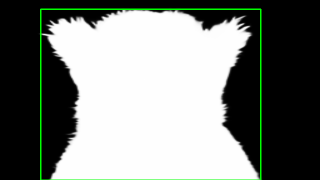

0.1265625 0.05 0.6875 0.95
x:81, y:18, hW:342, wW:440
Height:360, Weight:640

BASNET 52000:


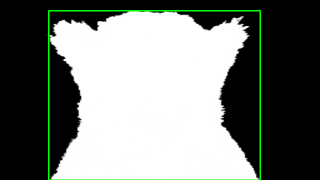

0.1515625 0.058333333333333334 0.6609375 0.9416666666666667
x:97, y:21, hW:339, wW:423
Height:360, Weight:640

BASNET 4000:


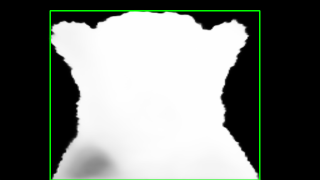

0.15625 0.058333333333333334 0.6546875 0.9416666666666667
x:100, y:21, hW:339, wW:419
Height:360, Weight:640
Time:  0.5473651885986328 



In [10]:
# --------- 4. inference for each image ---------
for i_test, data_test in enumerate(test_salobj_dataloader):
  start = time.time()	
  print("\ninferencing:",img_name_list[i_test].split("/")[-1])
  
  inputs_test = data_test['image']
  inputs_test = inputs_test.type(torch.FloatTensor)
  if torch.cuda.is_available():
    inputs_test = Variable(inputs_test.cuda())
  else:
    inputs_test = Variable(inputs_test)
    
  d1,d2,d3,d4,d5,d6,d7,d8 = net(inputs_test)
  d1_1,_,_,_,_,_,_,_ = net1(inputs_test)
  d1_2,_,_,_,_,_,_,_ = net2(inputs_test)
  
  # normalization
  pred = d1[:,0,:,:]
  pred = normPRED(pred)

  pred1 = d1_1[:,0,:,:]
  pred1 = normPRED(pred1)

  pred2 = d1_2[:,0,:,:]
  pred2 = normPRED(pred2)	

  print("\nBASNET:")
  save_output(img_name_list[i_test],pred,prediction_dir)
  print("\nBASNET 52000:")
  save_output(img_name_list[i_test],pred1,prediction_dir)
  print("\nBASNET 4000:")
  save_output(img_name_list[i_test],pred2,prediction_dir)
  print("Time: ", time.time() - start, "\n")
  break
  del d1,d2,d3,d4,d5,d6,d7,d8
